Exercise 3.5:

Calculating Efficient Frontiers and Bootstrapping Efficient Frontiers

In [203]:
#Lets First Load our Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [161]:
logRet = pd.read_csv("m_logret_10stocks.txt", sep = "\t")
numAssets = len(logRet.columns) - 1
numObs = logRet.shape[0]
logRet.head()

,Date,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL
0,1/3/1994,0.048913,0.135255,-0.022896,0.062311,-0.012589,0.089236,-0.004332,0.000000,0.023481,0.049109
1,2/1/1994,0.048849,-0.014934,-0.009507,0.020685,0.059586,-0.002166,-0.014386,-0.026850,-0.013543,0.010790
2,3/1/1994,-0.040761,-0.078928,0.000873,0.162273,0.000000,-0.071433,-0.007948,0.014169,0.011634,-0.010790
3,4/4/1994,-0.044394,0.041945,0.002175,-0.073436,-0.059586,-0.117886,0.002286,0.022294,0.038426,-0.031135
4,5/2/1994,-0.009572,0.031889,0.015763,0.010089,0.121734,-0.018289,0.003406,0.041424,0.064941,0.057625


In [150]:
#need to define a function that will return sample statistics given a dataset

#Note, the "1:" in the splicing excludes the date column from the calculation
def sampleStat(data):
    sampleMean = data.iloc[:,1:].mean(axis = 0)
    sampleCov = data.iloc[:, 1:].cov()
    return (sampleMean, sampleCov)

In [151]:
#For now, lets just calculate these statistics on the time series as a whole
sampleMean, sampleCov = sampleStat(logRet)
print(sampleMean)


AAPL    0.006894
ADBE    0.007686
ADP     0.003922
AMD     0.002309
DELL    0.011894
GTW    -0.002486
HP      0.005012
IBM     0.005677
MSFT    0.007293
ORCL    0.006934
dtype: float64


In [152]:
#Lets define a function that takes in a sampleMean, sampleCov, targetReturn, and risk free rate
#and outputs the optimal Weight portfolio for the given expected output

#assume retMean, retCov, riskFree are given as matrices
def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
        
    weightDenominator = np.matmul(np.transpose(riskAdjMean),np.matmul(inverseCov, riskAdjMean))
    weightCoeff = (targetReturn - riskFree[0,0])/ weightDenominator[0,0]
    optimalWeights = weightCoeff * np.matmul(inverseCov, riskAdjMean)
    return optimalWeights

In [153]:
rf = 0.0
targetReturn = 0.3

#Turn needed df's into matrices for easy computation
riskFree = np.full((numAssets,1), rf)
sampleMeanMatrix = sampleMean.to_numpy()
sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
sampleCovMatrix = sampleCov.to_numpy()

#Call optimal function to find optimal weights for tReturn
optimalWeights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, targetReturn, riskFree)

In [154]:
print(optimalWeights)

[[ 2.24572914]
 [ 3.93290198]
 [10.22236781]
 [-2.71968247]
 [10.83002332]
 [-8.78400811]
 [ 2.73156011]
 [ 3.19481   ]
 [ 4.50290193]
 [ 0.74283374]]


In [155]:
#Let's check that our expected return is correct, and the associated variance of the portfoli
expectedReturn = np.matmul(np.transpose(optimalWeights), sampleMeanMatrix)
expectedVariance = np.matmul(np.transpose(optimalWeights), np.matmul(sampleCovMatrix, optimalWeights))

print("Expected Return: " + str(expectedReturn[0,0]))
print("Expected Variance: " + str(expectedVariance[0,0]))

Expected Return: 0.29999999999999993
Expected Variance: 0.9099730003217619


In [180]:
def bootStrapWeights(data, statisticFunction, targetReturn, riskFree, B = 500):
    #initialize some constants
    cumWeights = np.zeros((numAssets,1))
    riskFree = np.full((numAssets,1), rf)
    
    for i in range(1,B):
        iMean, iCov = sampleStat(data.sample(n = numObs, replace = True))
        iMeanMatrix = iMean.to_numpy()
        iMeanMatrix = iMeanMatrix.reshape((numAssets,1))
        iCovMatrix = iCov.to_numpy()
        iOptWeight = optimalWeight(iMeanMatrix, iCovMatrix, targetReturn, riskFree)
        cumWeights = np.add(cumWeights, iOptWeight)
    
    cumWeights = cumWeights * (1.0/B)
    return cumWeights
    

In [182]:
bootWeights = bootStrapWeights(logRet, sampleStat, targetReturn, riskFree)
print(bootWeights)
print(optimalWeights)

[[ 1.74179998]
 [ 2.66662429]
 [ 6.0332421 ]
 [-1.87506584]
 [ 6.78533864]
 [-5.54498388]
 [ 1.66762035]
 [ 2.30966624]
 [ 3.23992156]
 [ 0.47081763]]
[[ 2.24572914]
 [ 3.93290198]
 [10.22236781]
 [-2.71968247]
 [10.83002332]
 [-8.78400811]
 [ 2.73156011]
 [ 3.19481   ]
 [ 4.50290193]
 [ 0.74283374]]


In [186]:
#To create the efficient frontier, we need to create a grid of expected Returns
#and compute the minimum variance for each

mu = np.linspace(-0.5,0.5,101)
sig = np.empty(len(mu))
for idx, optRet in enumerate(mu):
    iOptWeight = optimalWeight(sampleMeanMatrix, sampleCovMatrix, optRet, riskFree)
    isig = np.matmul(np.transpose(iOptWeight), np.matmul(sampleCovMatrix,iOptWeight))
    sig[idx] = isig
    

<function matplotlib.pyplot.show(close=None, block=None)>

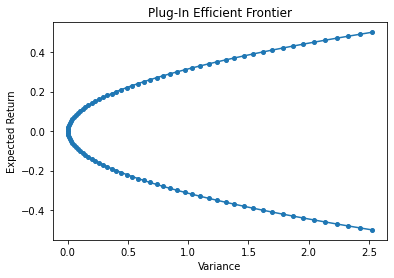

In [195]:
#Plot this EF

plt.title("Plug-In Efficient Frontier") 
plt.xlabel("Variance") 
plt.ylabel("Expected Return")
plt.plot(sig, mu, marker = "o", markersize = 4, label = "Plug-in")
plt.show

In [198]:
#Now do the same for the bootstrapped samples
bootSig = np.empty(len(mu))
for idx, optRet in enumerate(mu):
    iOptWeight = bootStrapWeights(logRet, sampleStat, optRet, riskFree)
    isig = np.matmul(np.transpose(iOptWeight), np.matmul(sampleCovMatrix,iOptWeight))
    bootSig[idx] = isig



<function matplotlib.pyplot.show(close=None, block=None)>

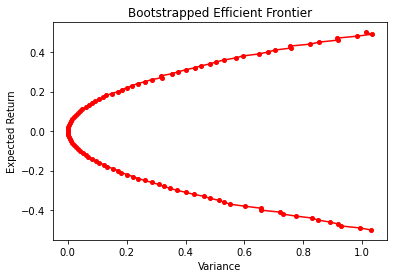

In [200]:
plt.title("Bootstrapped Efficient Frontier") 
plt.xlabel("Variance") 
plt.ylabel("Expected Return")
plt.plot(bootSig, mu, color = "red", marker = "o", markersize = 4, label = "Bootstrap")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

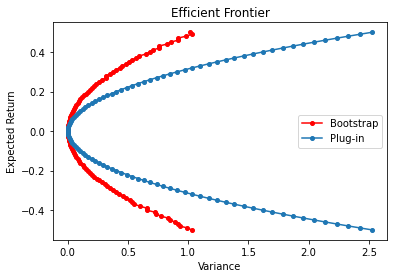

In [201]:
#Now lets overlay these two EF
plt.title("Efficient Frontier") 
plt.xlabel("Variance") 
plt.ylabel("Expected Return")
plt.plot(bootSig, mu, color = "red", marker = "o", markersize = 4, label = "Bootstrap")
plt.plot(sig, mu, marker = "o", markersize = 4, label = "Plug-in")
plt.legend()
plt.show
